# Описание проекта

В рамках проекта этого модуля необходимо создать модель, которая сможет распознавать числа на изображениях

Распознавание чисел на изображениях — это задача многоклассовой классификации. В качестве объекта, для которого необходимо предсказать класс, выступает изображение. Возможных классов столько, сколько в данных представлено чисел, которые необходимо научиться распознавать

В качестве данных для решения задачи будут использоваться изображения из базы данных MNIST — классического набора данных для создания и проверки качества работы алгоритмов компьютерного зрения

MNIST состоит из чёрно-белых изображений рукописных цифр. В базе представлены изображения цифр от 0 до 9. Каждое изображение имеет разрешение 28×28 пикселей

В данных, которые будут использоваться для решения задачи, представлено 42 000 изображений. Это подмножество всех данных, доступных в MNIST

Описание таблицы

Изображение размером 28×28 представляется в виде последовательности из 784 чисел — по одному числу на каждый пиксель изображения. Каждое число находится в диапазоне от 0 до 255. Чем больше число, тем выше интенсивность пикселя. Нулевой интенсивности соответствует абсолютно чёрный пиксель, максимальной — абсолютно белый

Каждое изображение представляется в виде строчки в таблице images.csv. В таблице есть колонки pixel0, pixel1 и так далее до pixel783, каждая из которых соответствует значению конкретного пикселя изображения. Также в таблице есть колонка label, в которой находится информация о том, какая цифра представлена на изображении

In [1]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Для улучшения модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

## Обработка данных

In [4]:
images_base = pd.read_csv('images.csv')

In [5]:
images_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


<Axes: xlabel='label', ylabel='Count'>

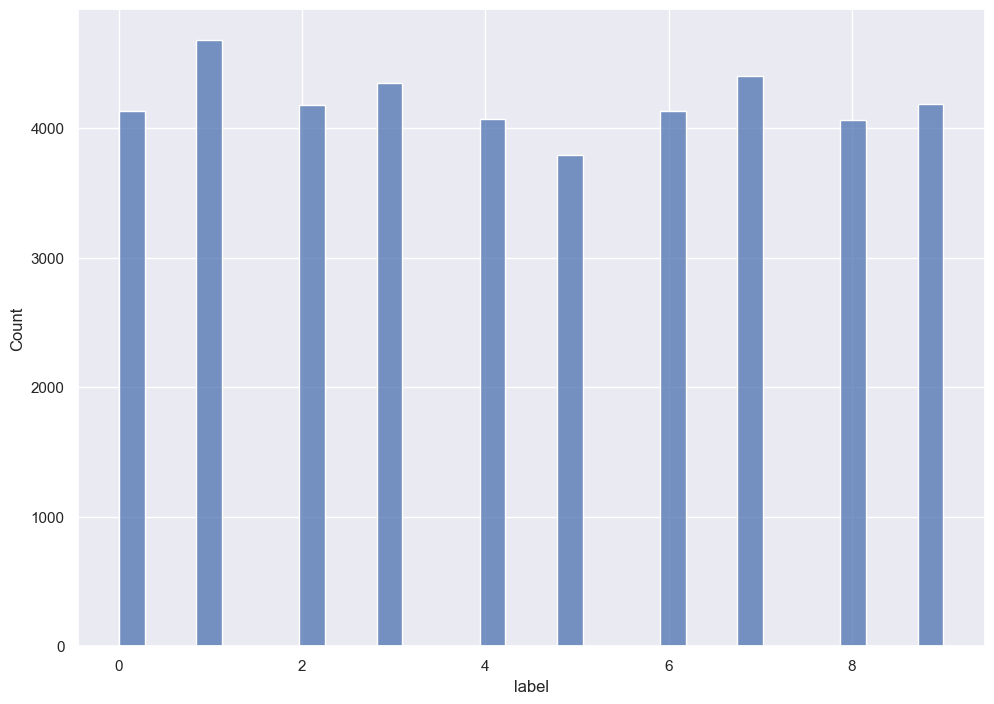

In [6]:
sns.histplot(images_base['label'])

Нет явного дисбаланса классов

Нарисуем какое-либо число из данной таблицы. Посколько в таблице указано 784 пикселя, то понадобится матрица 28 на 28

In [7]:
def print_image(image_flat, ax=None):
    image = image_flat.reshape(28, 28).astype('uint8')
    
    if ax is None:
        plt.imshow(image)
    else:
        ax.axis('off')
        ax.imshow(image)

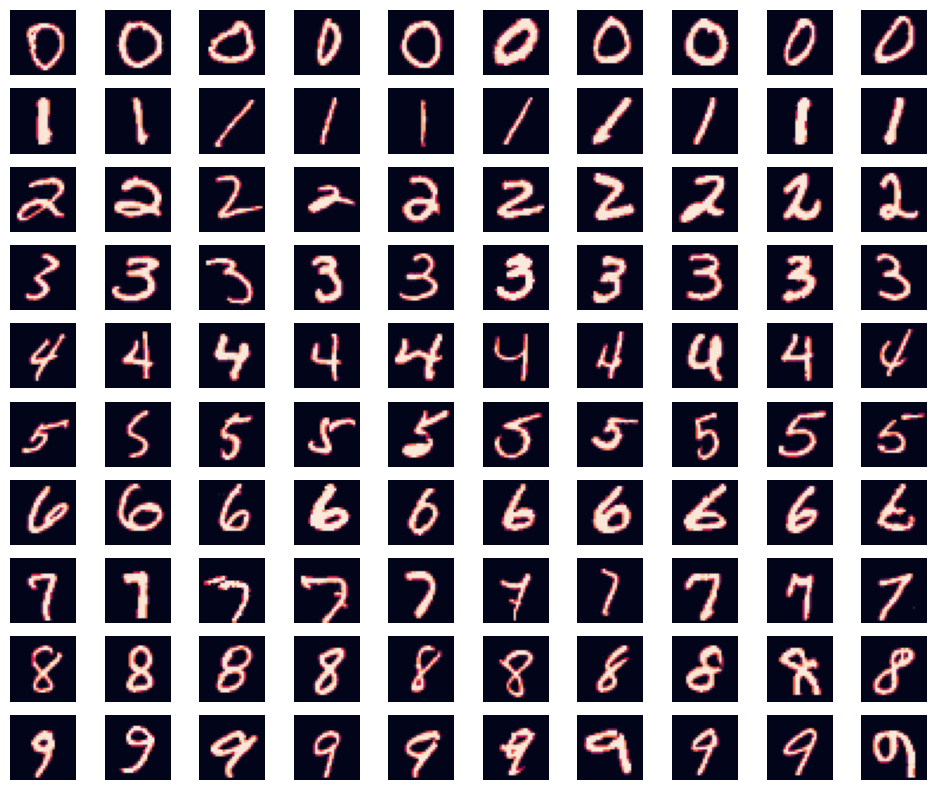

In [8]:
fig, axs = plt.subplots(10, 10, figsize=(12,10),
                       sharex=True, sharey=True)

group_n = 0
for _, group in images_base.groupby('label', as_index=False):
    random_numbers = group.sample(10).drop(columns='label')
    image_vects = [x.values for _, x in random_numbers.iterrows()]
    
    image_n = 0
    for image in image_vects:
        print_image(image, ax=axs[group_n][image_n])
        image_n += 1
        
    group_n += 1

Заметим, что много пустых полей, которые не несут информации о представленном числе. Посмотрим распределение пикселей на графике

<Axes: >

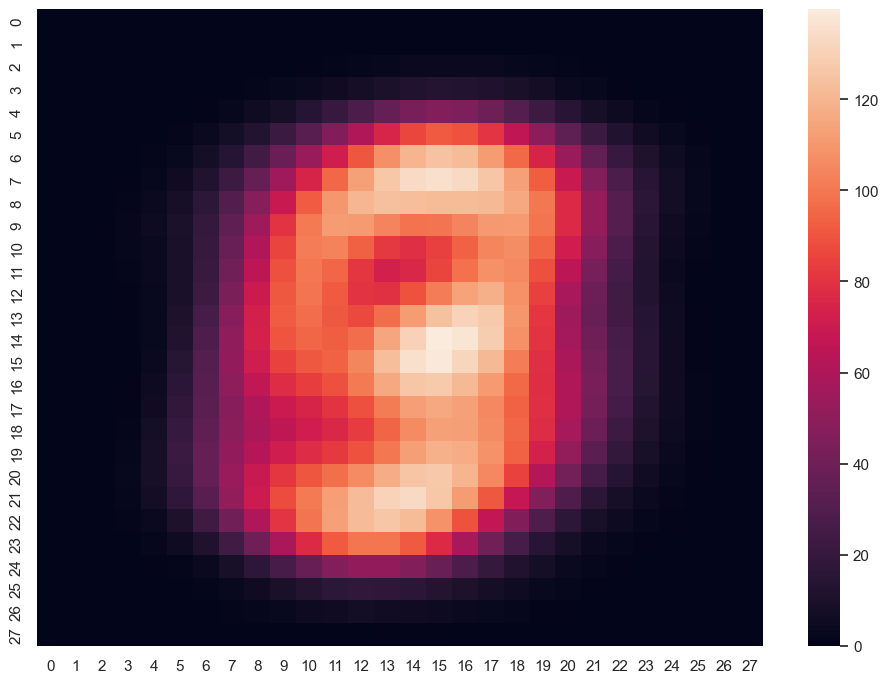

In [9]:
sns.heatmap(pd.DataFrame(images_base.drop(columns = 'label').mean().values.reshape(28, 28)))

<Axes: >

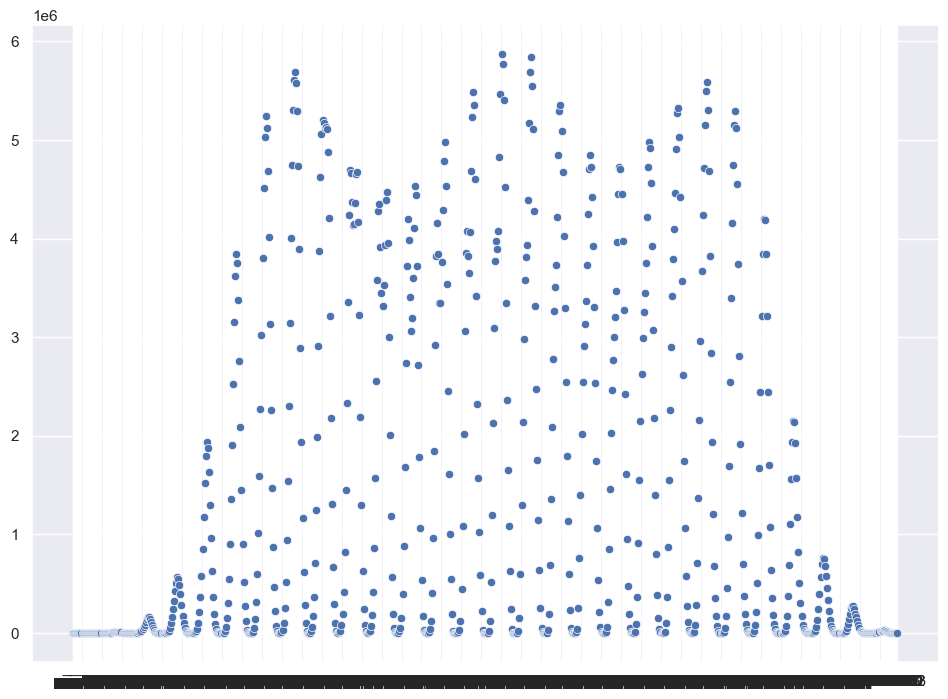

In [10]:
sns.scatterplot(images_base.drop(columns = 'label').sum())

Заметим, что суммарная интенсивность пикселя может достигать величины около 6 млн. для данных

In [11]:
important_factors = []
for column in images_base.drop(columns = 'label').columns:
    if images_base[column].sum() > 0:
        important_factors += [column]

In [12]:
len(important_factors)

708

In [13]:
important_factors = ['label'] + important_factors

In [14]:
images_base = images_base[important_factors]

In [15]:
images_base.sample(5)

,label,pixel12,pixel13,pixel14,pixel15,pixel32,pixel33,pixel34,pixel35,pixel36,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779
31629,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2767,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9751,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36579,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25065,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Создание модели без случайного леса с созданием своих функций и класса

Для ускорения выполнения кода будем рассматривать только 1000 чисел

In [16]:
images = images_base.sample(1000)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(images.drop(columns = 'label'), images['label'], test_size = 0.2)

In [18]:
images_train = X_train.copy()
images_train['label'] = y_train
images_test = X_test.copy()
images_test['label'] = y_test

In [19]:
class Node:
    def __init__(self, 
                 factor_ind, 
                 threshold, 
                 left_node, 
                 right_node):
        """
        Конструктор объекта «вершина дерева».
        
        Аргументы:
            factor_ind: Индекс фактора, про который задаётся вопрос в вершине.
            threshold: Пороговое значение, с которым сравнивается значение фактора в вершине.
            left_node: Вершина, содержащая левое поддерево текущей вершины.
            right_node: Вершина, содержащая правое поддерево текущей вершины.
        """
        
        self.factor_ind = factor_ind
        self.threshold = threshold
        
        self.left_node = left_node
        self.right_node = right_node
        
    def is_leaf(self):
        """
        Возвращает значение False, которое соответствует тому, что объект не является листом.
        """
        
        return False
        
class Leaf:
    def __init__(self, 
                 predicted_value):
        """
        Конструктор объекта «лист дерева».
        
        Аргументы:
            predicted_value: Значение, которое является предсказанием в данной листе.
        """
        
        self.predicted_value = predicted_value
        
    def is_leaf(self):
        """
        Возвращает значение True, которое соответствует тому, что объект является листом.
        """
        
        return True

In [20]:
def decision_tree_predict_solution(cur_node, x):
    """
    Производит предсказание значения для объекта x с помощью заданного дерева принятия решений.
    
    Аргументы:
        cur_node: Корневая вершина дерева, с помощью которого производится предсказание.
        x: Объект, для которого происходит предсказание.
        
    Возвращаемое значение:
        Предсказанное значение для объекта x.
        Если в листьях дерева записан класс, то возвращается класс,
        если в листьях дерева записано численное значение, то возвращается число.
    """
    if cur_node.is_leaf():
        return cur_node.predicted_value

    factor_ind = cur_node.factor_ind
    threshold = cur_node.threshold
    if x.iat[factor_ind] >= threshold:
        return decision_tree_predict_solution(cur_node.right_node, x)
    else:
        return decision_tree_predict_solution(cur_node.left_node, x)

In [21]:
def gini_index_solution(X):
    """
    Производит вычисление хаотичности данных с помощью критерия Джини.
    
    Аргументы:
        X: Набор объектов, представленный в виде матрицы размера n x m.
           Каждая строка матрицы соответствует объекту.
           Каждый объект описывается (m - 1) фактором, а также классом, которому принадлежит.
           Класс представляется числом.
           Индекс класса в строке объекта — (m - 1), если считать, что индексация в векторе идёт от 0.
        
    Возвращаемое значение:
        Вычисленное значение хаотичности данных, округлённое до 3 знаков после запятой.
    """
    if len(X) == 0:
        return 0.0
    
    y = X[:, -1]
    unique_classes, counts = np.unique(y, return_counts=True)
    
    total = len(y)
    proportions = counts / total
    gini = 1 - np.sum(proportions ** 2)
    
    return gini

In [22]:
def data_split_solution(X, factor_ind, factor_value):
    """
    Производит разбиение данных на две части в зависимости от значения конкретного фактора
    по следующему правилу: объекты в X, для которых значение фактора с индексом factor_ind больше или равно factor_value,
    идут в правую часть разбиения, остальные — в левую.
    
    Аргументы:
        X: Набор объектов, представленный в виде матрицы размера n x m.
           Каждая строка матрицы соответствует объекту.
           Каждый объект описывается (m - 1) фактором, а также классом, которому принадлежит.
           Класс представляется числом.
           Индекс класса в строке объекта — (m - 1), если считать, что индексация в векторе идёт от 0.
        factor_ind: Индекс фактора, по которому происходит разбиение.
        factor_value: Пороговое значение, по которому происходит разбиение.
        
    Возвращаемое значение:
        Пара из X_l и X_r, где X_l и X_r — левая и правая части разбиения, соответственно.
        Важно, что порядок объектов в X_l и X_r должен быть таким же, как в X.
        То есть если какие-то две строчки шли друг за другом в X, а после разбиения вместе оказались,
        например, в X_l, то идти друг за другом в X_l они должны в том же порядке, в котором шли в X.
    """
    
    X_l = X[X[:, factor_ind] < factor_value]
    X_r = X[X[:, factor_ind] >= factor_value]
    
    return X_l, X_r

In [23]:
def optimal_split_parameters_grid_search_solution(X):
    """
    Находит оптимальные параметры разбиения данных на левую и правую части.
    Оптимальность разбиения определяется с помощью критерия Джини.
    
    Аргументы:
        X: Набор объектов, представленный в виде матрицы размера n x m.
           Каждая строка матрицы соответствует объекту.
           Каждый объект описывается (m - 1) фактором, а также классом, которому принадлежит.
           Класс представляется числом.
           Индекс класса в строке объекта — (m - 1), если считать, что индексация в векторе идёт от 0.
        
    Возвращаемое значение:
        Пара из индекса фактора и порогового значения,
        при которых достигается оптимальное разбиение данных.
    """
    if len(X) == 0:
        return 0, 0
    
    best_factor_ind = 0
    best_factor_value = X[0][0]
    best_Q = - float('inf')
    H = gini_index_solution(X)
    
    for factor_ind in range(len(X[0]) - 1):
        unique_values = np.unique(X[:, factor_ind])
        
        for factor_value in unique_values:
            X_l, X_r = data_split_solution(X, factor_ind, factor_value)

            if len(X_l) == 0 or len(X_r) == 0:
                continue
                
            H_l = gini_index_solution(X_l)
            H_r = gini_index_solution(X_r)
            Q = H - len(X_l)/len(X) * H_l - len(X_r)/len(X) * H_r
            
            if Q > best_Q:
                best_factor_ind = factor_ind
                best_factor_value = float(factor_value)
                best_Q = Q
    
    return best_factor_ind, best_factor_value

In [24]:
def build_node_solution(X, cur_depth=1, max_depth=7):
    """
    Строит дерево принятия решений.
    
    Аргументы:
        X: Набор объектов, представленный в виде матрицы размера n x m.
           Каждая строка матрицы соответствует объекту.
           Каждый объект описывается (m - 1) фактором, а также классом, которому принадлежит.
           Класс представляется числом.
           Индекс класса в строке объекта — (m - 1), если считать, что индексация в векторе идёт от 0.
        cur_depth: Опциональный параметр, по умолчанию равен 1.
                   Глубина, на которой строится текущая вершина.
        max_depth: Опциональный параметр, по умолчанию равен None.
                   Максимальная глубина дерева.
                   Если значение параметра равно None, то на глубину дерева
                   не накладывается ограничений в процессе построения дерева.
        
    Возвращаемое значение:
        Построенное на данных из X дерево принятия решений, которое либо состоит
        из вершины, к которой присоединены рекурсивно построенные поддеревья,
        либо состоит из одного листа с предсказанием.
    """
    X = np.array(X)
    
    if len(X) == 0:
        return Leaf(0)
    
    y = X[:, -1]
    
    unique_classes, counts = np.unique(y, return_counts = True)
    
    max_count = np.max(counts)
    most_frequent_classes = unique_classes[counts == max_count]
    best_class = float(np.min(most_frequent_classes))
    
    if (max_depth != None and cur_depth > max_depth) or max_count == len(X):
        return Leaf(best_class)
    
    best_factor_ind, best_factor_value = optimal_split_parameters_grid_search_solution(X)
    X_l, X_r = data_split_solution(X, best_factor_ind, best_factor_value)
    
    if len(X_l) == 0 or len(X_r) == 0:
        return Leaf(best_class)
    
    left_node = build_node_solution(X_l, cur_depth + 1, max_depth)
    right_node = build_node_solution(X_r, cur_depth + 1, max_depth)
    
    return Node(best_factor_ind, best_factor_value, left_node, right_node)

In [25]:
images_tree = build_node_solution(images_train)

In [26]:
def print_tree(cur_node, s=''):
    """
    Производит печать на экран дерева, представленного в виде вершин и листьев.
    
    Аргументы:
        cur_node: Корневая вершина дерева, которое нужно напечатать.
        s: Опциональный параметр. Задаёт отступ при печати
        
    Возвращаемое значение:
        На экран будет выведено дерево в следующем формате:
        
        Вершина 0 (корневая вершина)
            Вершина 1 (левая вершина от вершины 0)
                ... и так далее до листьев
            Вершина 2 (правая вершина от вершины 0)
                ... и так далее до листьев
    """
    
    if cur_node.is_leaf():
        print(s + f'Лист(предсказание={cur_node.predicted_value})')
        return
    
    print(s + f'Вершина(фактор={cur_node.factor_ind}, порог={cur_node.threshold})')
    
    print_tree(cur_node.left_node, s + '    ')
    print_tree(cur_node.right_node, s + '    ')

In [27]:
print_tree(images_tree, s='')

Вершина(фактор=516, порог=5.0)
    Вершина(фактор=381, порог=10.0)
        Вершина(фактор=333, порог=88.0)
            Вершина(фактор=331, порог=29.0)
                Вершина(фактор=464, порог=31.0)
                    Вершина(фактор=112, порог=150.0)
                        Вершина(фактор=356, порог=213.0)
                            Лист(предсказание=7.0)
                            Лист(предсказание=9.0)
                        Вершина(фактор=80, порог=172.0)
                            Лист(предсказание=4.0)
                            Лист(предсказание=3.0)
                    Вершина(фактор=84, порог=11.0)
                        Вершина(фактор=139, порог=139.0)
                            Лист(предсказание=7.0)
                            Лист(предсказание=9.0)
                        Лист(предсказание=2.0)
                Вершина(фактор=601, порог=16.0)
                    Лист(предсказание=6.0)
                    Вершина(фактор=106, порог=26.0)
                        Вершина

In [28]:
images_pred = pd.DataFrame()
images_pred['pred'] = images_train.drop(columns = 'label').apply(lambda row: decision_tree_predict_solution(images_tree, row), axis = 1)

In [29]:
images_pred.head()

,pred
15855,1.0
24124,3.0
15541,2.0
19621,2.0
4707,6.0


In [30]:
images_pred['y'] = images_train['label']

In [31]:
images_pred.sample(10)

,pred,y
12279,7.0,7
11551,1.0,1
41625,2.0,2
39017,3.0,3
35387,6.0,6
1282,6.0,6
30048,6.0,6
7924,1.0,1
21898,8.0,8
25652,5.0,8


In [32]:
images_pred['acc'] = images_pred['y'] == images_pred['pred']

In [33]:
images_pred['acc'].mean()

np.float64(0.9275)

In [34]:
images_test_pred = pd.DataFrame()
images_test_pred['pred'] = images_test.drop(columns = 'label').apply(lambda row: decision_tree_predict_solution(images_tree, row), axis = 1)

images_test_pred['y'] = images_test['label']

images_test_pred['acc'] = images_test_pred['y'] == images_test_pred['pred']

In [35]:
images_test_pred['acc'].mean()

np.float64(0.585)

Видим точность в 65 процент угадывания чисел модель, что весьма низкий показатель. Возникает необходимость использовать случайный лес

## Создание модели с использованием библиотеки

Для начала стоит удалить пиксели с нулевой дисперсией в факторах, т.к. такие факторы не учат модель различать объекты. Они в себя включаются в том числе и факторы с нулевой суммой по объектам, которые были удалены в прошлый раз

In [36]:
images_base = pd.read_csv('images.csv')

In [37]:
images = images_base.copy()

In [38]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [39]:
X_train, X_test, y_train, y_test = train_test_split(images.drop(columns = 'label'), images['label'], test_size = 0.2)

Используем метод DecisionTreeClassifier для создания модели дерева принятия решения

In [40]:
model_decision_tree = DecisionTreeClassifier(min_samples_leaf = 10, criterion = 'gini')

In [41]:
model_decision_tree.fit(X_train, y_train) 

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [42]:
y_acc = pd.DataFrame()
y_acc['y'] = y_test
y_acc['pred'] = model_decision_tree.predict(X_test)

In [43]:
y_acc.head()

,y,pred
4193,2,8
22326,6,6
23346,6,6
31691,5,9
17233,5,8


In [44]:
y_acc['acc'] = (y_acc['y'] == y_acc['pred'])

In [45]:
y_acc['acc'].mean()

np.float64(0.8520238095238095)

Получилась точность предсказания в 85 процентов

<Axes: >

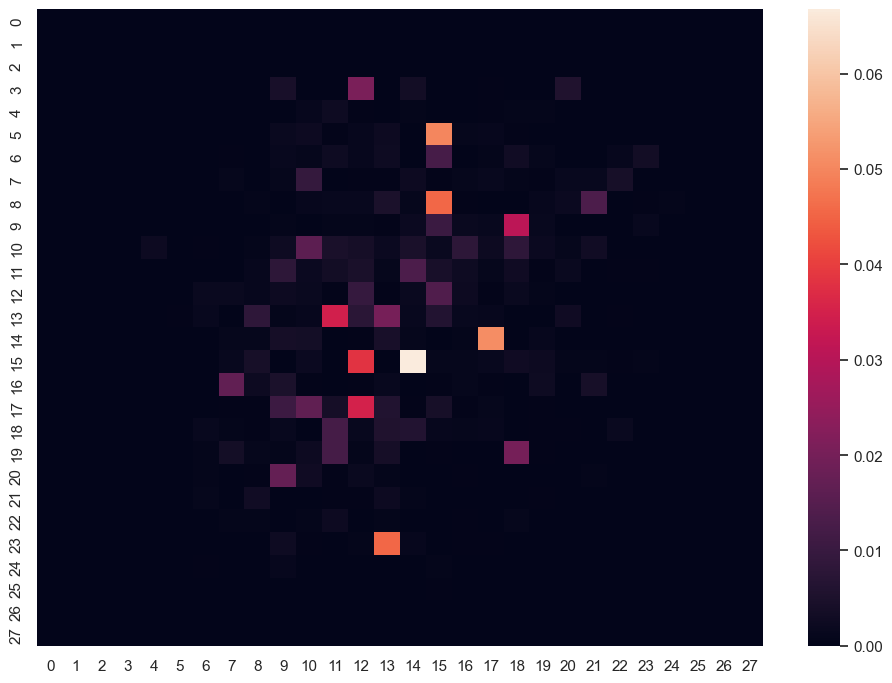

In [46]:
sns.heatmap(model_decision_tree.feature_importances_.reshape(28, 28))

In [47]:
model_decision_tree.feature_importances_.max()

np.float64(0.06676880121441534)

In [48]:
model_decision_tree.feature_names_in_[model_decision_tree.feature_importances_ > 0.01]

array(['pixel96', 'pixel155', 'pixel183', 'pixel239', 'pixel245',
       'pixel267', 'pixel270', 'pixel290', 'pixel322', 'pixel351',
       'pixel375', 'pixel377', 'pixel409', 'pixel432', 'pixel434',
       'pixel455', 'pixel485', 'pixel486', 'pixel488', 'pixel515',
       'pixel543', 'pixel550', 'pixel569', 'pixel657'], dtype=object)

## Создание модели со случайным лесом с использованием библиотеки

In [49]:
images_base = pd.read_csv('images.csv')
images = images_base.copy()

In [50]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [51]:
model_random_forest = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 3, max_features = 5, criterion = 'gini')

In [52]:
X_train, X_test, y_train, y_test = train_test_split(images.drop(columns = 'label'), images['label'], test_size = 0.2)

In [53]:
model_random_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
y_acc = pd.DataFrame()
y_acc['y'] = y_test.copy()
y_acc['pred'] = model_random_forest.predict(X_test)

In [55]:
y_acc['acc'] = y_acc['y'] == y_acc['pred']

In [56]:
y_acc['acc'].mean()

np.float64(0.9482142857142857)

In [57]:
model_random_forest.score(X_test, y_test)

0.9482142857142857

<Axes: >

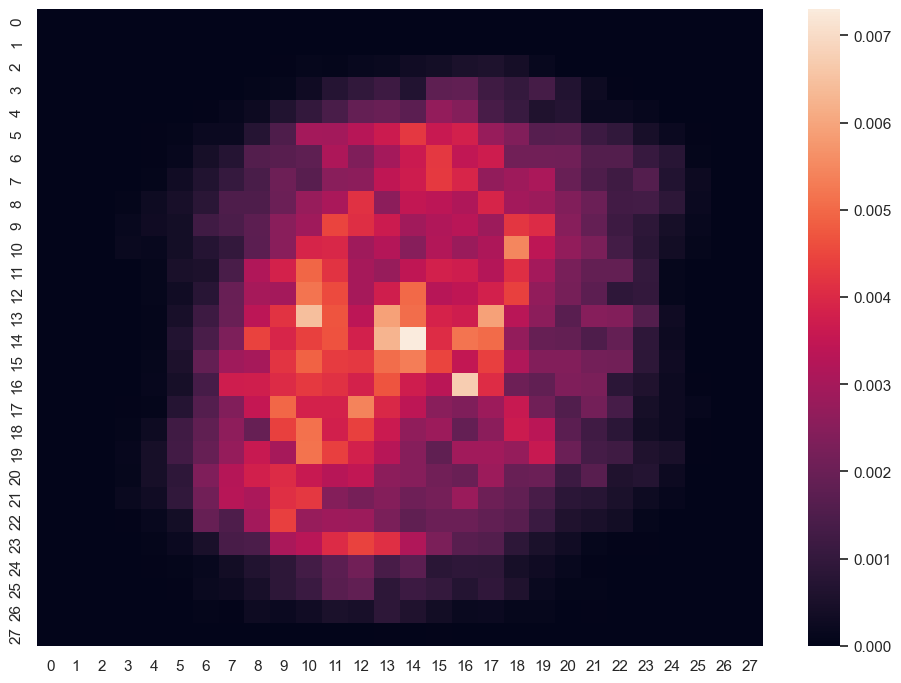

In [58]:
sns.heatmap(model_random_forest.feature_importances_.reshape(28, 28))

In [59]:
model_random_forest.feature_importances_.max()

np.float64(0.0073012671826598015)

In [60]:
model_random_forest.feature_names_in_[model_random_forest.feature_importances_ > 0.0045]

array(['pixel298', 'pixel318', 'pixel346', 'pixel347', 'pixel350',
       'pixel374', 'pixel375', 'pixel377', 'pixel378', 'pixel381',
       'pixel403', 'pixel405', 'pixel406', 'pixel408', 'pixel409',
       'pixel430', 'pixel433', 'pixel434', 'pixel461', 'pixel464',
       'pixel485', 'pixel488', 'pixel514', 'pixel542'], dtype=object)

Представлены самые значимые пиксели для обучения модели